이제 해야 할 작업
✅ 1. 매파/비둘기 시드 세트 벡터화
- 사전에 정의된 hawkish / dovish 단어를 벡터로 변환 *완료*
- 해당 벡터들의 평균을 구해서 대표 벡터로 사용 *완료*

✅ 2. 모든 n-gram과 시드 세트 간 코사인 유사도 계산
- 각 n-gram 벡터와 hawkish / dovish 시드 벡터 간 유사도 측정
- 유사도 차이가 기준값 이상이면 매파/비둘기로 분류, 아니면 제외

✅ 3. 전파 알고리즘 (Propagation) 적용
- 논문에서 제시한 방식처럼, 10개의 랜덤 서브셋을 만들고 50번 반복 학습
- 학습 결과를 바탕으로 최종 polarity lexicon 구축

✅ 4. 문서 기반 감성 분석 및 기준금리 예측과 연계
- 구축한 lexicon을 바탕으로 새로운 문서들의 감성 점수 계산
- 과거 데이터를 이용해 감성 점수와 금리 변동 간의 상관관계 분석
- 최종적으로 예측 모델과 연계

# 극성 사전 만들기

## 논문 분석
- ngram2vec을 이용한 매파 / 비둘기파 감성분석 모델
- seed sets에서 랜덤으로 10개의 단어를 뽑아 sub sets 만듦
- 이를 바탕으로 50번의 propagation (전파)를 시행함
- 이들을 통해 bootstrap할 수 있음

In [80]:
from gensim.models import Word2Vec

model = Word2Vec.load('/content/drive/MyDrive/BOK-TEAM-2/모델링/ngram2vec_lexicon/ngram2vec_filtered.model')
# 모델 로드에 소요되는 시간: 23초 시스템 RAM 2.3기가

In [ ]:
model.wv.most_similar('미국', topn=30) # 유사도 너무 작게 나와서 재학습 시킬 거임 -> 똑같이 나와서 우선 그냥

[('틱 외국인 은행 계약 계약', 0.26922664046287537),
 ('부작용 지적', 0.25459524989128113),
 ('수출업체 네고물량 출회 상승 폭', 0.2522205114364624),
 ('중후 순위', 0.2518126368522644),
 ('한국 독일 이탈리아', 0.25156867504119873),
 ('미국 금리 달러', 0.2477254569530487),
 ('생각 답', 0.24674773216247559),
 ('발표 이후 국제 금융', 0.24521802365779877),
 ('한국 과거', 0.23918908834457397),
 ('거래일 대비 상승 거래 국채선물', 0.23774035274982452),
 ('상품 공동', 0.23683933913707733),
 ('통화 긴축 기조 강화', 0.23524513840675354),
 ('발표 신종', 0.2342464029788971),
 ('단기 채권시장', 0.233932226896286),
 ('방향 통안채 통안채 국고채 통안채', 0.23220157623291016),
 ('글', 0.23055338859558105),
 ('회선', 0.23039060831069946),
 ('엔달러 역외 위안', 0.22706136107444763),
 ('국내 인하', 0.22697541117668152),
 ('눈길 채권시장', 0.22592410445213318),
 ('기술적 보조', 0.22394172847270966),
 ('파란색 칸', 0.2215590924024582),
 ('외무 장관', 0.22082124650478363),
 ('유가 많이', 0.22056466341018677),
 ('효과 전달', 0.22053483128547668),
 ('특별 재료 없', 0.2201966494321823),
 ('변경상장', 0.21987737715244293),
 ('생산 통안채 만기 만기 고용동향', 0.21962490677833557),
 ('

## 1. seed sets 구축, subsets 제작
    1. NBC를 활용한 사전을 사용할까?
    2. 아니면 논문에 나와있는 기본 시드를 사용할까?
    3. 우리가 구축한 사전 바탕 자료 탐색하고 구축해 보기

In [81]:
# seed sets를 구축하기 위한 사전 데이터 분석
import pandas as pd
word_dic = pd.read_csv('/content/drive/MyDrive/BOK-TEAM-2/모델링/word_dictionary_ver4.csv', dtype = str)

word_dic # 995124 rows × 2 columns
# Nan 값 확인: dovish 단어가 231149개 부족 word_dic.isnull().sum()

# 양쪽에 같은 단어가 있다면, 모호성이 크다고 보고 df에서 삭제해줄 것
# ex) 양족 모두 있을 법한 '금리' 라는 단어는 삭제해도 됨

# 1. 둘을 다른 데이터 프레임으로 분리한다. dovish / hawkish
df_hawkish = pd.DataFrame(word_dic['hawkish'], dtype=str)
df_dovish = pd.DataFrame(word_dic['dovish'], dtype=str)
# 2. 둘을 비교해가면서 중복으로 들어간 데이터는 두 df 모두에서 삭제 해 본다.
# 2-1.. 우선 각 df 내에서 중복된 값을 지움
df_hawkish = df_hawkish.drop_duplicates()
df_dovish = df_dovish.drop_duplicates()
# 2-2. 둘을 순회하면서 서로 중복된 값을 지운다.
common_values = set(df_hawkish['hawkish']).intersection(set(df_dovish['dovish']))
# 교집합에 해당하는 값 삭제
df_hawkish = df_hawkish[~df_hawkish['hawkish'].isin(common_values)]
df_dovish = df_dovish[~df_dovish['dovish'].isin(common_values)]
# 인덱스를 0부터 재설정
df_hawkish = df_hawkish.reset_index(drop=True)
df_dovish = df_dovish.reset_index(drop=True)

# 3. 개수를 확인하고, 순서를 확인해서 구축한다.
df_hawkish.dropna(inplace=True)
df_dovish.dropna(inplace=True)

# 이를 통해 어떻게 사전을 구축할 수 있을 것인가? - 연관이 높은 상위 25개 단어? 30개 단어? 이 부분은 조금 더 고민이 필요함
# 쓰려면 공백 사이 언더바는 모두 제거해야 함 check -> 내 거 형식에 맞춰서
# 금리 상승과 금리 하락은 들어가야 하지 않을까? -> hawkish와 dovish로 만든 거니까 그대로 가자

# 논문과 같이 상위 25개를 사용, 같은 방식으로 propagation 진행
# 사전과 mv에서 찾을 수 없다고 나오는 단어가 많아서, 우선 30개로 늘려서 시행해 봄

# 1. 데이터 처리: 언더바를 모두 제거한 리스트를 만듦
# hawkish 단어 리스트 처리
hawkish = df_hawkish['hawkish'].head(30).str.replace("_", " ", regex=False).tolist()
# dovish 단어 리스트 처리
dovish = df_dovish['dovish'].head(30).str.replace("_", " ", regex=False).tolist()
hawkish

['스텝',
 '빅 스텝',
 '포인트 인상',
 '인상 폭',
 '우크라이나 전쟁',
 '러시아 우크라이나',
 '높 물가',
 '인상 기조',
 '변이',
 '암호화폐',
 '스타트업',
 '높 인플레이션',
 '자산시장',
 '가상 자산',
 '중심 나스닥지수',
 '기술주 중심 나스닥지수',
 '수요 둔화',
 '촉발',
 '중점',
 '중고차',
 '수석 이코노미스트',
 '상승률 둔화',
 '부동',
 '수신 금리',
 '액티브',
 '부동 산원',
 '다우존스30산업평균지수 거래일',
 '금리 인상 사이클',
 '산원',
 '사기']

In [64]:
# 논문에 나와 있는 사전으로 seed sets를 구축해 보자
# 사전 형태 부여하면 될 것 같음

hawkish = ['높', '팽창' ,'인상' ,'매파', '성장',
           '투기 억제', '상승', '인플레이션 압력', '증가', '위험 선호',
           '상회', '물가 상승', '과열', '금리 상승', '확장',
           '상방 압력', '긴축', '변동성 감소', '흑자', '채권 가격 하락',
           '견조', '요금 인상', '낙관', '부동산 가격 상승', '상향']

dovish = ['낮', '축소' ,'인하' ,'비둘기', '둔화',
           '악화', '하락', '회복 못', '감소', '위험 회피', # 회복 못하 -> 회복 못으로 수정
           '하회', '물가 하락', '위축', '금리 하락', '침체',
           '하방 압력', '완화', '변동성 확대', '적자', '채권 가격 상승',
           '견조', '요금 인하', '비관', '부동산 가격 하락', '하향']
# 사전
# 매파 : 1 , 비둘기파 : 0
polarity_lexicon = {word: 1 for word in hawkish}
polarity_lexicon.update({word:-1  for word in dovish})

# subsets 만들기
# 랜덤으로 각각 10개씩
def make_subset(hawkish, dovish):
    import random
    random.seed()
    hawkish_sub = random.sample(hawkish, 10)
    dovish_sub = random.sample(dovish, 10)
    # 모델 짤 때 사용 가능함

In [82]:
# 모델을 통한 테스트
for haw in hawkish:
    try:
        print(haw, model.wv.most_similar(haw, topn=2))
    except KeyError:
        print(f"KeyError: '{haw}' 단어는 사전에서 찾을 수 없습니다.")
        continue  # KeyError 발생 시, 계속해서 다음 단어로 넘어감

for dov in dovish:
    try:
        print(dov, model.wv.most_similar(dov, topn=2))
    except KeyError:
        print(f"KeyError: '{dov}' 단어는 사전에서 찾을 수 없습니다.")
        continue  # KeyError 발생 시, 계속해서 다음 단어로 넘어감

스텝 [('개별 민평 개별 민평 개별', 0.261961430311203), ('모습 현지', 0.25205159187316895)]
빅 스텝 [('구간 단순', 0.28082218766212463), ('브렉시트 추가', 0.2551964819431305)]
포인트 인상 [('원리금 상환 부담 소비', 0.276593416929245), ('증대 가계', 0.2518996596336365)]
인상 폭 [('자회사 신용공여 한도', 0.25781896710395813), ('PF 신용공여', 0.257813960313797)]
우크라이나 전쟁 [('투자 신규 건설 고정자산 투자', 0.26957279443740845), ('산 시가총액', 0.26674824953079224)]
러시아 우크라이나 [('물량 전반', 0.2720213532447815), ('공사 도시', 0.26523879170417786)]
높 물가 [('달러 약세 환율', 0.26771318912506104), ('증가 오후 채권딜러', 0.2535437047481537)]
인상 기조 [('달러원환율 뉴욕', 0.2730180323123932), ('목숨', 0.25482961535453796)]
변이 [('거래 증권 계약 외국인', 0.2759850025177002), ('분기 국내총생산 개인 소비 지출', 0.2624552249908447)]
암호화폐 [('강세 효과', 0.2757549583911896), ('이벤트', 0.2731437087059021)]
스타트업 [('별도 제공', 0.257200688123703), ('부채 협상', 0.25136327743530273)]
높 인플레이션 [('부실 현실화', 0.2955365777015686), ('팀 무역지수 교역조건 물가 통계', 0.28510305285453796)]
자산시장 [('분양권 웃돈', 0.3012463450431824), ('경제 호조세', 0.26710236072540283)]
가상 자산 [('국민주택채권', 0.

In [83]:
# 전체 vocabulary 확인
from gensim.models import Word2Vec
# model = Word2Vec.load("/content/drive/MyDrive/BOK-TEAM-2/모델링/ngram2vec_lexicon/ngram2vec_filtered.model")
vocab = model.wv.key_to_index  # 모든 단어의 목록
ngrams = list(vocab.keys()) # 양이 많아서 나눠서 해야 함
print(f"전체 vocabulary에 포함된 단어 수: {len(vocab)}")

전체 vocabulary에 포함된 단어 수: 555588


## 2. Seed Sets를 활용한 학습
우선 논문에 주어진 seedwords를 활용하여 시행해 보는 것을 목표로 함

    1. 딥러닝 외 단순한 방법
        - 사전을 벡터화하고, 그와 유사한 유사도를 가진 것들을 각각 매파, 비둘기파로 분류
        - 머신러닝의 classification 모델을 사용할 수 있을까?
        - 코사인 유사도나 그래프 기반으로 점수 부여 ( 부여한 점수를 바탕으로 매파/비둘기파 구분)

    2. 딥러닝 사용 가능
        - 비선형적 문제로 볼 수는 없을까?
        - GNN이나 Transformer를 활용할 수 있음 (ChatGPT)
        - 인공신경망? MLP?

```
 With this resulting n-gram vector,
 we bootstrap by running our propagation 50 times
 over 10 andom equally sized subsets of the hawkish and dovish seed sets.
  ```


In [ ]:
# 코사인 유사도 기반 score 부여하는 코드

# 1. seet sets에 있는 word를 벡터화 하기

# 2. model 내의 ngram들과 코사인 유사도 측정

# 3. 측정한 코사인 유사도를 바탕으로 hwakish인지, dovish인지 판단하기
# 이때, hawkish한 word와의 유사도 평균 / dovish한 word와의 유사도 평균
# 단, 둘의 차가 000 이하일 때는 버림
# hawkish, dovish 문서 리스트 만들기

In [84]:
from random import seed
import numpy as np
# 매파 / 비둘기 시드 세트 벡터화
# 논문에 나와 있는 사전으로 seed sets를 구축해 보자
# 사전 형태 부여하면 될 것 같음

# 사전
# 매파 : 1 , 비둘기파 : 0
# polarity_lexicon = {word: 1 for word in hawkish}
# polarity_lexicon.update({word:-1  for word in dovish})
seed_sets = {'hawksih': hawkish, 'dovish':dovish}

# subsets 만들기
# 랜덤으로 각각 10개씩
def make_subset(hawkish, dovish):
    import random
    random.seed()
    hawkish_sub = random.sample(hawkish, 10)
    dovish_sub = random.sample(dovish, 10)
    # 모델 짤 때 사용 가능함
    return hawkish_sub
    return dovish_sub

# 매파 / 비둘기파 벡터의 평균을 구하자
def get_average_vector(words, model):
    # 벡터화
    vectors = [model.wv[word]  for word in words if word in model.wv]
    # 벡터 평균 계산
    if len(vectors) == 0 :
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# 벡터 사이의 코사인 유사도 구하기

In [ ]:
len(ngrams) # 555588

555588

In [85]:
# 매파와 비둘기파의 벡터 평균 구하기
hawkish_vector = get_average_vector(hawkish, model)
dovish_vector = get_average_vector(dovish, model)

vocab = model.wv.key_to_index  # 모든 단어의 목록
ngrams = list(vocab.keys()) # 양이 많아서 나눠서 해야 함

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
# 코사인 유사도를 바탕으로 분류하기
def classification_bycsim(ngrams, model, hawkish_vector, dovish_vector):
    hawkish_list = []
    dovish_list = []
    for ngram in ngrams:
        try:
            ngram_vector = model.wv[ngram]
            # 코사인 유사도 계산
            similarity_hawkish = cosine_similarity([ngram_vector], [hawkish_vector])
            similarity_dovish = cosine_similarity([ngram_vector], [dovish_vector])
            # 비교
            if abs(similarity_hawkish - similarity_dovish) > 0.1 : # 특정 값
                if similarity_hawkish > similarity_dovish :
                    hawkish_list.append(ngram)
                    # print(f"{ngram}: 매파")
                else:
                    dovish_list.append(ngram)
                    # print(f"{ngram}: 비둘기파")
        except KeyError:
            print("KeyError.")
    df = pd.DataFrame({'hawkish': pd.Series(hawkish_list), 'dovish': pd.Series(dovish_list)})
    return df

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

df_result = classification_bycsim(ngrams, model, hawkish_vector, dovish_vector) # 코사인 유사도 기반 분류

KeyboardInterrupt: 

In [ ]:
df_result['dovish'] # 단순히 전체 리스트를 사용했을 때의 모습

df_result.to_csv('/content/drive/MyDrive/BOK-TEAM-2/모델링/ngram2vec_lexicon/lexicon_total.csv')

NameError: name 'df_result' is not defined

In [87]:
# 전파 알고리즘을 적용히야 합니다. how to?
import random
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

def make_subset(hawkish, dovish):
    random.seed()
    hawkish_sub = random.sample(hawkish, 5)
    dovish_sub = random.sample(dovish, 5)
    return (hawkish_sub, dovish_sub)

# 전파만
vocab = model.wv.key_to_index
ngrams = list(vocab.keys()) # ngram들 리스트 정의

def propagation(hawkish, dovish, model, iterations=50, threshold=0.17):
    polarity_scores = {word: 1 for word in hawkish}
    polarity_scores.update({word: -1 for word in dovish})
    confirmed_ngrams = set(polarity_scores.keys())

    vocab = model.wv.key_to_index
    ngrams = list(vocab.keys())

    # 모든 n-gram 벡터 미리 저장 (행렬 형태로 변환)
    ngram_vectors = np.array([model.wv[ngram] for ngram in ngrams])

    hawkish_vector = np.array(get_average_vector(hawkish, model)).reshape(1, -1)
    dovish_vector = np.array(get_average_vector(dovish, model)).reshape(1, -1)

    for i in range(iterations):
        updated_ngrams = []

        similarities_hawkish = cosine_similarity(ngram_vectors, hawkish_vector).flatten()
        similarities_dovish = cosine_similarity(ngram_vectors, dovish_vector).flatten()

        for idx, ngram in enumerate(ngrams):
            if ngram in confirmed_ngrams:
                continue

            similarity_hawkish = similarities_hawkish[idx]
            similarity_dovish = similarities_dovish[idx]

            if similarity_hawkish > threshold and similarity_dovish < threshold:
                polarity_scores[ngram] = 1
                updated_ngrams.append(ngram)
            elif similarity_hawkish < threshold and similarity_dovish > threshold:
                polarity_scores[ngram] = -1
                updated_ngrams.append(ngram)
            elif similarity_hawkish > threshold and similarity_dovish > threshold:
                polarity_scores[ngram] = 1 if similarity_hawkish > similarity_dovish else -1
                updated_ngrams.append(ngram)

        confirmed_ngrams.update(updated_ngrams)

    return polarity_scores  # return 위치 수정 (루프 바깥으로 이동)

def run_propagation_on_subsets(subsets, model, iterations=50):
    all_polarity_scores = []
    count = 1

    for hawkish_sub, dovish_sub in subsets:
        result = propagation(hawkish_sub, dovish_sub, model, iterations)
        all_polarity_scores.append(result)
        print(f'{count}. 완료')
        count += 1

    return all_polarity_scores



In [88]:
subsets = [make_subset(hawkish, dovish) for _ in range(10)] # 여기서의 hawkish와 dovish는 사전 기반
all_scores = run_propagation_on_subsets(subsets, model)
all_scores[:4]

1. 완료
2. 완료
3. 완료
4. 완료
5. 완료
6. 완료
7. 완료
8. 완료
9. 완료
10. 완료


[{'부동 산원': 1,
  '중고차': 1,
  '액티브': 1,
  '다우존스30산업평균지수 거래일': 1,
  '인상 기조': 1,
  '수출업체 네고물량': -1,
  '채권시장 국고채': -1,
  '자산운용사 채권': -1,
  '타워': -1,
  '시티': -1,
  '전개 관련': -1,
  '비중 확대 중립': -1,
  '높 완화': -1,
  '성장주 상대적': -1,
  '증시 차별화': 1,
  '대표 제안': -1,
  '빨대': -1,
  '온라인 대출 중개 플랫폼': -1,
  '가격 일시적': -1,
  '투자자 외화자금 수요': -1,
  '미국 단독': -1,
  '대면 서비스': -1,
  '경제 재개 관련': 1,
  '간 신용': 1,
  '전환 장중': 1,
  '상위 기록 자금흐름 국내': -1,
  '물가 상승세 지속': -1,
  '지역 시가 초과': 1,
  '올해 상장': 1,
  '아직 불확실성': -1,
  '미국 뉴욕증시 일제히 하락': 1,
  '코로나 확산 초기': 1,
  '전년 동월 대비 전월': 1,
  '유동성 장세 실적 장세': -1,
  '주요 국과 비교': 1,
  '하락 인도분 금': 1,
  '금융당국 등록': -1,
  '기사 포털': -1,
  '중소기업 취업자': -1,
  '바이러스 감염증 확산 세': 1,
  '수출신용보증': 1,
  '성장주 유리 환경': -1,
  '권 광석 은행장': -1,
  '사회 상생': 1,
  '기환': -1,
  '친환경 사업 투자': -1,
  '접종 본격': -1,
  '인플레이션 완전고용': 1,
  '국채 금리 상승 뉴욕증시': -1,
  '대출 관리 서비스': 1,
  '기준 코스닥 지수': -1,
  '외평채 성공': 1,
  '기관 홀로': 1,
  '우세 전망': 1,
  '플러스 달러': 1,
  '일시적 상승': -1,
  '디딤돌 대출 대상': -1,
  '논고': -1,
  '주택 공실': 1,
  '중소기업 보증': 1

In [72]:
### 논문 seed word 바탕으로 한

import pandas as pd

def save_scores_to_csv_separated(all_scores, filename="/content/drive/MyDrive/BOK-TEAM-2/모델링/ngram2vec_lexicon/ngram_polarity_separated.csvv"):
    """
    전파된 감성 점수 데이터를 'ngram'을 기준으로 'hawkish'과 'dovish' 컬럼으로 변환하여 CSV 파일로 저장.

    Parameters:
        all_scores (list of dict): 각 subset에 대한 polarity 점수 결과 리스트
        filename (str): 저장할 CSV 파일명 (기본값: "ngram_polarity_separated.csv")

    Returns:
        DataFrame: 변환된 데이터프레임 (저장된 CSV 파일 경로 출력)
    """
    # 모든 점수를 하나의 딕셔너리로 병합
    merged_scores = {}

    for score_dict in all_scores:
        for ngram, score in score_dict.items():
            if ngram not in merged_scores:
                merged_scores[ngram] = {"hawkish": 0, "dovish": 0}
            if score == 1:
                merged_scores[ngram]["hawkish"] += 1
            elif score == -1:
                merged_scores[ngram]["dovish"] += 1

    # DataFrame 변환
    df = pd.DataFrame.from_dict(merged_scores, orient="index").reset_index()
    df.columns = ["ngram", "hawkish", "dovish"]

    # CSV 저장
    df.to_csv(filename, index=False, encoding="utf-8")
    print(f"✅ 감성 점수 데이터가 '{filename}' 파일로 저장되었습니다!")

    return df

# 사용 예시
df = save_scores_to_csv_separated(all_scores,"/content/drive/MyDrive/BOK-TEAM-2/모델링/ngram2vec_lexicon/ngram_polarity_separated.csv")

print(df.head(5))

# 각 ngram이 10개 subset에서 몇 번씩 hawkish(1), dovish(-1)로 분류되었는지 확인 가능!

# 부트스트랩 없이 그냥 10번 세트로 50번 전파 / 빈도수로 확인

✅ 감성 점수 데이터가 '/content/drive/MyDrive/BOK-TEAM-2/모델링/ngram2vec_lexicon/ngram_polarity_separated_19.csv' 파일로 저장되었습니다!
      ngram  hawkish  dovish
0  채권 가격 하락        1       0
1     위험 선호        3       0
2        확장        3       0
3     요금 인상        4       0
4    변동성 감소        3       0


In [89]:
### NBC seed words를 바탕으로 한

import pandas as pd

# 사용 예시
df = save_scores_to_csv_separated(all_scores,"/content/drive/MyDrive/BOK-TEAM-2/모델링/ngram2vec_lexicon/(dict_ver4)ngram_polarity_separated.csv")

print(df.head(5))

# 각 ngram이 10개 subset에서 몇 번씩 hawkish(1), dovish(-1)로 분류되었는지 확인 가능!

# 부트스트랩 없이 그냥 10번 세트로 50번 전파 / 빈도수로 확인

✅ 감성 점수 데이터가 '/content/drive/MyDrive/BOK-TEAM-2/모델링/ngram2vec_lexicon/(dict_ver4)ngram_polarity_separated.csv' 파일로 저장되었습니다!
              ngram  hawkish  dovish
0             부동 산원        1       0
1               중고차        2       0
2               액티브        1       0
3  다우존스30산업평균지수 거래일        4       0
4             인상 기조        3       0


In [93]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/BOK-TEAM-2/모델링/ngram2vec_lexicon/(dict_ver4)ngram_polarity_separated.csv')
h_list = []
d_list = []
for idx in range(len(df)) :
    if df['dovish'][idx] > df['hawkish'][idx]:
        h_list.append('O')
        d_list.append(np.nan)
    else:
        d_list.append('O')
        h_list.append(np.nan)

df['매파'] = h_list
df[df['매파']=='O'] # 7728개
df['비둘기파'] = d_list
df[df['비둘기파']=='O'] # 7012개



   # - 특정 값을 가지고 있는 행만 추출: df[df['컬럼명'] == '특정 값']

,ngram,hawkish,dovish,매파,비둘기파
0,부동 산원,1,0,NaN,O
1,중고차,2,0,NaN,O
2,액티브,1,0,NaN,O
3,다우존스30산업평균지수 거래일,4,0,NaN,O
4,인상 기조,3,0,NaN,O
...,...,...,...,...,...
16115,연방준비제도의장 유럽중앙은행,1,0,NaN,O
16117,금리 제조업 호조,1,0,NaN,O
16119,등락 거듭 미국,1,0,NaN,O
16120,증가 국고여유자금 환수 세입 자금조정예금,1,0,NaN,O


In [ ]:
# 해당 데이터를 바탕으로 lexicon 만들기

# hwkish / dovish 구분하기

# 각각 빈도수 높은 순으로 정렬하기

# hawish / dovish 로 나눈 lexicon 생성
# 갯수 부족하지 않은지 확인 다시

### 시각화

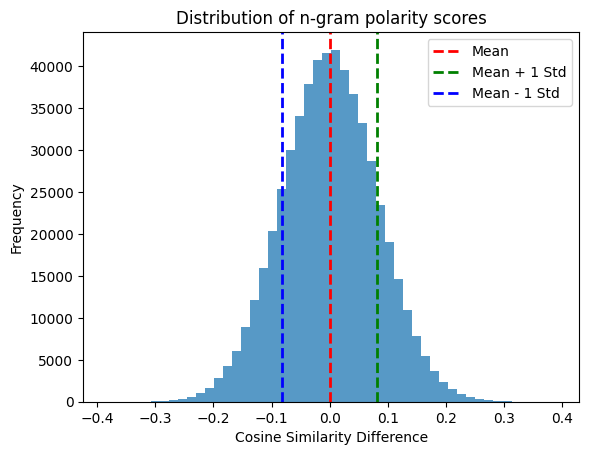

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 모든 n-gram의 코사인 유사도 차이 계산
ngram_scores = []

for ngram in model.wv.index_to_key:
    hawkish_sim = cosine_similarity([model.wv[ngram]], [hawkish_vector])[0][0]
    dovish_sim = cosine_similarity([model.wv[ngram]], [dovish_vector])[0][0]
    score = hawkish_sim - dovish_sim
    ngram_scores.append(score)

# 평균과 표준편차 계산
mean_score = np.mean(ngram_scores)
std_score = np.std(ngram_scores)

# 임계값 설정 (평균 ± 1 표준편차)
threshold = std_score  # 또는 mean_score ± std_score

# 히스토그램으로 분포 확인
plt.hist(ngram_scores, bins=50, alpha=0.75)
plt.axvline(mean_score, color='r', linestyle='dashed', linewidth=2, label="Mean")
plt.axvline(mean_score + std_score, color='g', linestyle='dashed', linewidth=2, label="Mean + 1 Std")
plt.axvline(mean_score - std_score, color='b', linestyle='dashed', linewidth=2, label="Mean - 1 Std")
plt.legend()
plt.xlabel("Cosine Similarity Difference")
plt.ylabel("Frequency")
plt.title("Distribution of n-gram polarity scores")
plt.show()


In [ ]:
mean_score = np.mean(ngram_scores)
std_score = np.std(ngram_scores)
print(mean_score)
print(std_score)

1.3184448e-05
0.08175177


In [ ]:
# chatgpt 제안 -> 최적화
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from numba import jit, prange
import multiprocessing as mp
import time

@jit(nopython=True, parallel=True)
def fast_cosine_similarity(vectors, reference_vector):
    dot_product = np.dot(vectors, reference_vector.T)
    norm_product = np.linalg.norm(vectors, axis=1) * np.linalg.norm(reference_vector)
    return dot_product / norm_product

def parallel_propagation(hawkish, dovish, model, iterations=50, threshold=0.2, num_workers=4):
    polarity_scores = {word: 1 for word in hawkish}
    polarity_scores.update({word: -1 for word in dovish})
    confirmed_ngrams = set(polarity_scores.keys())

    vocab = model.wv.key_to_index
    ngrams = np.array(list(vocab.keys()))  # numpy 배열로 변환 (연산 최적화)
    ngram_vectors = np.array([model.wv[ngram] for ngram in ngrams])

    hawkish_vector = np.array(get_average_vector(hawkish, model)).reshape(1, -1)
    dovish_vector = np.array(get_average_vector(dovish, model)).reshape(1, -1)

    for i in range(iterations):
        updated_ngrams = []

        # 🎯 **멀티 프로세싱 활용 (병렬 연산)**
        with mp.Pool(processes=num_workers) as pool:
            similarities_hawkish = pool.starmap(fast_cosine_similarity, [(ngram_vectors, hawkish_vector)])
            similarities_dovish = pool.starmap(fast_cosine_similarity, [(ngram_vectors, dovish_vector)])

        similarities_hawkish = np.array(similarities_hawkish).flatten()
        similarities_dovish = np.array(similarities_dovish).flatten()

        for idx in range(len(ngrams)):
            ngram = ngrams[idx]
            if ngram in confirmed_ngrams:
                continue

            similarity_hawkish = similarities_hawkish[idx]
            similarity_dovish = similarities_dovish[idx]

            if similarity_hawkish > threshold and similarity_dovish < threshold:
                polarity_scores[ngram] = 1
                updated_ngrams.append(ngram)
            elif similarity_hawkish < threshold and similarity_dovish > threshold:
                polarity_scores[ngram] = -1
                updated_ngrams.append(ngram)
            elif similarity_hawkish > threshold and similarity_dovish > threshold:
                polarity_scores[ngram] = 1 if similarity_hawkish > similarity_dovish else -1
                updated_ngrams.append(ngram)

        confirmed_ngrams.update(updated_ngrams)

        if not updated_ngrams:
            print(f"✅ 조기 종료됨: {i + 1}회 반복 후 변화 없음")
            break

    return polarity_scores

# 실행 시간 체크
start_time = time.time()
result = parallel_propagation(hawkish, dovish, model, iterations=50, num_workers=4)
end_time = time.time()

print(f"⚡ 최적화된 실행 시간: {end_time - start_time:.4f}초")
